In [29]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom
import algotom.prep.calculation as calc
import h5py as h5f
import timeit
from joblib import Parallel, delayed

In [3]:
# %matplotlib notebook
%matplotlib inline

# Workflow starts here!

In [4]:
###################### need to change start
ipts="29298"
###################### need to change end

In [5]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
output_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(output_loc)

['2022_09_29_sample2.h5',
 '2022_09_29_sample1.h5',
 '2022_09_29_sample4.h5',
 '2022_09_29_sample3.h5']

In [8]:
###################### need to change start
sample_name = "2022_09_29_sample4"
output_hdf5 = output_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [9]:
losa.get_hdf_tree(output_hdf5)

 tomo
    │
    ├── meta
    │   │
    │   ├── ang_deg (783,)
    │   ├── ang_rad (783,)
    │   ├── fluctuation_corr (1,)
    │   ├── fname (783,)
    │   ├── minus_log (1,)
    │   ├── proj180_idx (1,)
    │   └── ring_rmv (1,)
    ├── proj
    │   │
    │   ├── dc_fake (1850, 750)
    │   ├── ob_fake (1850, 750)
    │   ├── proj_norm (783, 1850, 750)
    │   └── proj_rmv (783, 1850, 750)
    └── sino
        │
        ├── sino_norm (1850, 783, 750)
        └── sino_rmv (1850, 783, 750)


deque([' tomo',
       '    │',
       '    ├── meta',
       '    │   │',
       '    │   ├── ang_deg (783,)',
       '    │   ├── ang_rad (783,)',
       '    │   ├── fluctuation_corr (1,)',
       '    │   ├── fname (783,)',
       '    │   ├── minus_log (1,)',
       '    │   ├── proj180_idx (1,)',
       '    │   └── ring_rmv (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (1850, 750)',
       '    │   ├── ob_fake (1850, 750)',
       '    │   ├── proj_norm (783, 1850, 750)',
       '    │   └── proj_rmv (783, 1850, 750)',
       '    └── sino',
       '        │',
       '        ├── sino_norm (1850, 783, 750)',
       '        └── sino_rmv (1850, 783, 750)'])

In [40]:
proj_norm = losa.load_hdf(output_hdf5, key_path='tomo/proj/proj_norm')
proj_rmv = losa.load_hdf(output_hdf5, key_path='tomo/proj/proj_rmv')
ang_rad = losa.load_hdf(output_hdf5, key_path='tomo/meta/ang_rad')

In [9]:
proj_norm.shape

(783, 1850, 750)

In [10]:
sino_norm = losa.load_hdf(output_hdf5, key_path='tomo/sino/sino_norm')
sino_rmv = losa.load_hdf(output_hdf5, key_path='tomo/sino/sino_rmv')

In [30]:
rot_center = calc.find_center_360(sino_rmv[400], 900)
print(rot_center) # >> 1275.25

(390.72657775878906, 716.5468444824219, 1, 220.45315551757812)


In [28]:
rot_center = calc.find_center_360(sino_rmv[600], 900)
print(rot_center) # >> 1275.25

(391.6119918823242, 714.7760162353516, 1, 222.22398376464844)


In [41]:
proj_align = tomopy.align_joint(proj_rmv, ang=ang_rad, center=rot_center)

AttributeError: 'Dataset' object has no attribute 'max'

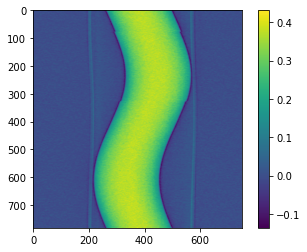

In [38]:
plt.imshow(sino_rmv[450])
plt.colorbar()
plt.show()

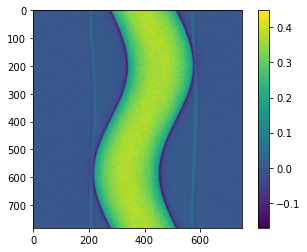

In [36]:
plt.imshow(sino_rmv[1450])
plt.colorbar()
plt.show()

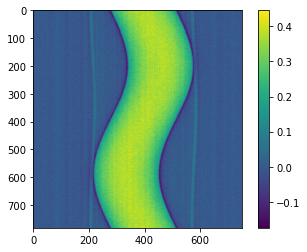

In [37]:
plt.imshow(tomopy.minus_log(sino_norm[1450]))
plt.colorbar()
plt.show()

In [11]:
proj_norm[:,600,:].shape

(783, 750)

# Export to HDF5

In [36]:
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo_norm')
    f.create_dataset('tomo_norm/proj', data=proj_norm)
    f.create_dataset('tomo_norm/ob', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo_norm/dc', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('config')
    f.create_dataset('config/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('config/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('config/proj180_idx', data=proj180_ind, dtype=np.uint16)
    f.create_dataset('config/fname', data=fname_sorted)

# Find and correct tilt

Tilt correction ROI at 0 degree:


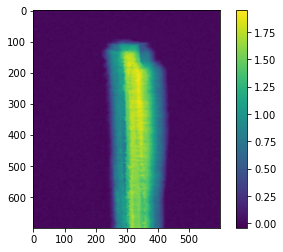

Tilt correction ROI at 180 degree:


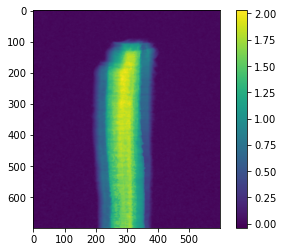

In [22]:
###################### need to change start
tt_xmin = 200
tt_xmax = 800
tt_ymin = 200
tt_ymax = 900
###################### need to change start
tt_roi = [tt_ymin, tt_xmin, tt_ymax, tt_xmax] # 
tt_0deg = proj_mlog[0, tt_roi[0]:tt_roi[2], tt_roi[1]:tt_roi[3]]
tt_180deg = proj_mlog[proj180_ind, tt_roi[0]:tt_roi[2], tt_roi[1]:tt_roi[3]]
print("Tilt correction ROI at 0 degree:")
plt.imshow(tt_0deg)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree:")
plt.imshow(tt_180deg)
plt.colorbar()
plt.show()

In [23]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=tt_0deg, image180=tt_180deg)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle...
Found the tilt angle:  0.07377669291773652


In [24]:
proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, tilt_ang.x)
# proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, 0.112)

# proj_tilt = tilt.apply_tilt_correction(proj_rmv, 0.112)

Applying tilt corr: 100%|██████████████████| 1000/1000 [00:09<00:00, 104.32it/s]


Projection at 0 degree:


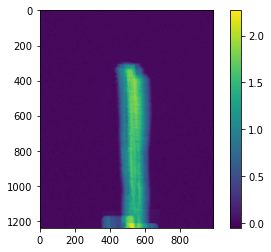

Projection at 180 degree (flipped):


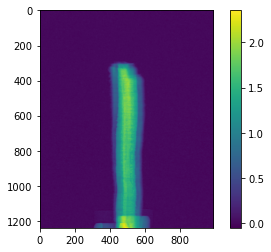

In [25]:
print("Projection at 0 degree:")
plt.imshow(proj_mlog[0])# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog[proj180_ind]))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Find Center of Rotation

In [28]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog[0,:,:]), np.squeeze(proj_mlog[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center) # 389.5

Estimated center of rotation: 513.5


In [27]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_rmv[0,:,:]), np.squeeze(proj_rmv[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center) # 389.5

Estimated center of rotation: 517.0


# Reconstruction

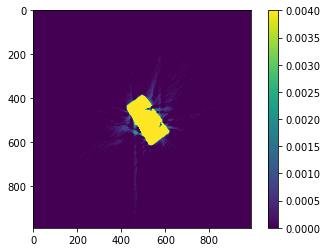

In [30]:
########## tomopy
recon = rocku.recon(proj_mlog_tilt, ang_rad, rot_center=rot_center, algorithm='gridrec')
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
plt.imshow(recon[600, :, :], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()

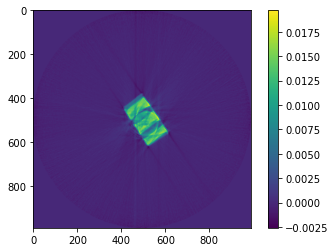

In [35]:
plt.imshow(recon[400, :, :])
plt.colorbar()
plt.show()

In [25]:
pix_um = 42.7 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm

# Export recon files

In [26]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_vo"
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)

# Export proj files (optional)

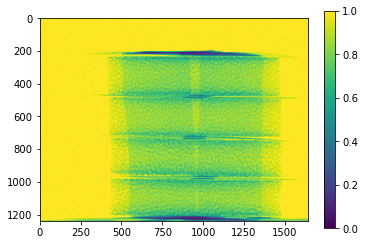

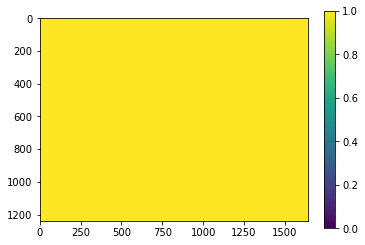

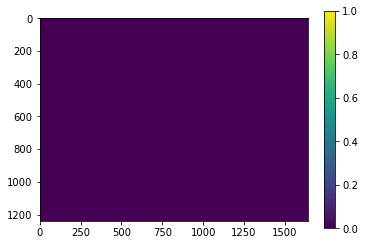

In [29]:
if proj_rmv.dtype == np.float32:
    proj_output = proj_rmv[:]
else:  
    proj_output = proj_rmv.astype(np.float32)
# proj_output = proj_norm.astype(np.float32)
# proj_output = np.exp(-1 * proj_output) # convert back to transmission
ob_output = np.ones((proj_output.shape[1],proj_output.shape[2]), dtype=proj_output.dtype)
dc_output = np.zeros((proj_output.shape[1],proj_output.shape[2]), dtype=proj_output.dtype)
plt.imshow(proj_output[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(ob_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(dc_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [59]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon/" + sample_name + "_norm"
dxchange.write_tiff_stack(proj_output, fname=save_to + "/raw", overwrite=True, digit=4)
dxchange.write_tiff(ob_output, fname=save_to + '/ob_0000', overwrite=True)
dxchange.write_tiff(dc_output, fname=save_to + '/dc_0000', overwrite=True)